### Problem 1: HandSign evaluation using CNNs

In [ ]:
!pip install tensorflow

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

##### *Data Preparation*

In [5]:
data_path = "sign_mnist_train.csv" 
data = pd.read_csv(data_path)

In [7]:
labels = data['label'].values  # The first column contains the labels
images = data.drop('label', axis=1).values  # Remaining columns are pixel values

# Normalize pixel values
images = images / 255.0

# Reshape images to 28x28 grayscale format
images = images.reshape(-1, 28, 28, 1)

labels = to_categorical(labels, num_classes=26)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

##### *Creating and training CNN model*

In [10]:
from tensorflow.keras.layers import Input
model = Sequential([
    Input(shape=(28, 28, 1)),
    
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.28),  # Regularization by dropout
    Dense(26, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3790 - loss: 2.0970 - val_accuracy: 0.9415 - val_loss: 0.2451
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9058 - loss: 0.2906 - val_accuracy: 0.9971 - val_loss: 0.0374
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9701 - loss: 0.1010 - val_accuracy: 0.9993 - val_loss: 0.0125
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9852 - loss: 0.0525 - val_accuracy: 0.9993 - val_loss: 0.0066
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9856 - loss: 0.0438 - val_accuracy: 0.9996 - val_loss: 0.0038
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9908 - loss: 0.0311 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9928 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9949 - loss: 0.0170 - 

##### *Evaluate and save the model*

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 1.0000


In [13]:
model.save("asl_cnn_model.keras")

In [15]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

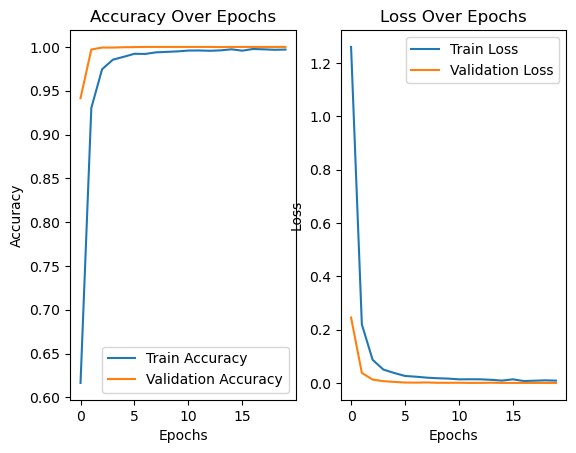

In [16]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [21]:
!pip install pydot

In [ ]:
# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

# Save the model architecture visualization as an image
from IPython.display import Image
Image(filename='model_architecture.png')

### Problem 2: Time Series Forecasting (Energy Consumption Forecasting) using LSTMs

##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#####  Load, prepare the dataset for model requirements

In [2]:
data_path = 'household_power_consumption.txt'

data = pd.read_csv(
    data_path,
    sep=';',
    parse_dates={'Date time': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['nan', '?'],
    low_memory=False
)
data.head()

C:\Users\hrish\AppData\Local\Temp\ipykernel_26912\4001346395.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
C:\Users\hrish\AppData\Local\Temp\ipykernel_26912\4001346395.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
C:\Users\hrish\AppData\Local\Temp\ipykernel_26912\4001346395.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(


,Date time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
data.dropna(inplace=True)

In [4]:
features = data.drop('Date time', axis=1)

# Convert all feature columns to numeric (if not already)
features = features.apply(pd.to_numeric, errors='coerce')

print("Data types after conversion:")
print(features.dtypes)

Data types after conversion:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


##### Set Datetime as Index

In [5]:
data.set_index('Date time', inplace=True)

##### Resample Data to Daily Energy Consumption

In [6]:
daily_data = pd.DataFrame()

In [7]:
daily_data['Global_active_power'] = data['Global_active_power'].resample('D').sum()
daily_data['Global_reactive_power'] = data['Global_reactive_power'].resample('D').sum()
daily_data['Sub_metering_1'] = data['Sub_metering_1'].resample('D').sum()
daily_data['Sub_metering_2'] = data['Sub_metering_2'].resample('D').sum()
daily_data['Sub_metering_3'] = data['Sub_metering_3'].resample('D').sum()

daily_data['Voltage'] = data['Voltage'].resample('D').mean()
daily_data['Global_intensity'] = data['Global_intensity'].resample('D').mean()

print("Resampled daily data:")
print(daily_data.head())

Resampled daily data:
            Global_active_power  Global_reactive_power  Sub_metering_1  \
Date time                                                                
2006-12-16             1209.176                 34.922             0.0   
2006-12-17             3390.460                226.006          2033.0   
2006-12-18             2203.826                161.792          1063.0   
2006-12-19             1666.194                150.942           839.0   
2006-12-20             2225.748                160.998             0.0   

            Sub_metering_2  Sub_metering_3     Voltage  Global_intensity  
Date time                                                                 
2006-12-16           546.0          4926.0  236.243763         13.082828  
2006-12-17          4187.0         13341.0  240.087028          9.999028  
2006-12-18          2621.0         14018.0  241.231694          6.421667  
2006-12-19          7602.0          6197.0  241.999313          4.926389  
2006-12-2

##### Handle Missing Values After Resampling

In [12]:
print("\nMissing values after resampling:")
print(daily_data.isnull().sum())

daily_data.ffill()


Missing values after resampling:
Global_active_power      0
Global_reactive_power    0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Voltage                  0
Global_intensity         0
dtype: int64


,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage,Global_intensity
Date time,,,,,,,
2006-12-16,1209.176,34.922,0.0,546.0,4926.0,236.243763,13.082828
2006-12-17,3390.460,226.006,2033.0,4187.0,13341.0,240.087028,9.999028
2006-12-18,2203.826,161.792,1063.0,2621.0,14018.0,241.231694,6.421667
2006-12-19,1666.194,150.942,839.0,7602.0,6197.0,241.999313,4.926389
2006-12-20,2225.748,160.998,0.0,2648.0,14063.0,242.308062,6.467361
...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,4855.0,2110.0,10136.0,240.197118,6.014167
2010-11-23,1577.536,137.450,1871.0,458.0,7611.0,240.575528,4.674444
2010-11-24,1796.248,132.460,1096.0,2848.0,12224.0,240.030965,5.249583


##### Normalize the Features

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_data)
scaled_df = pd.DataFrame(scaled_data, index=daily_data.index, columns=daily_data.columns)
print(scaled_df.head())

            Global_active_power  Global_reactive_power  Sub_metering_1  \
Date time                                                                
2006-12-16             0.253316               0.083579        0.000000   
2006-12-17             0.710284               0.540899        0.181875   
2006-12-18             0.461690               0.387216        0.095098   
2006-12-19             0.349059               0.361249        0.075058   
2006-12-20             0.466283               0.385316        0.000000   

            Sub_metering_2  Sub_metering_3   Voltage  Global_intensity  
Date time                                                               
2006-12-16        0.045090        0.207472  0.315385          0.928499  
2006-12-17        0.345776        0.561892  0.550494          0.695226  
2006-12-18        0.216451        0.590406  0.620518          0.424618  
2006-12-19        0.627798        0.261003  0.667476          0.311508  
2006-12-20        0.218680        0.592301 

##### Create Time Series Sequences

In [15]:
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i, :].values)  # Using .iloc for pandas DataFrame
        y.append(data.iloc[i, 0])  # Target is still from the first column
    return np.array(X), np.array(y)

# Define window size (e.g., past 30 days to predict the next day)
window_size = 30

scaled_df = scaled_df  # Ensure you're working with the DataFrame here

# Create sequences from scaled data
X, y = create_sequences(scaled_df, window_size)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (1412, 30, 7)
Shape of y: (1412,)


In [16]:
print(f"Shape of X after reshaping: {X.shape}")

Shape of X after reshaping: (1412, 30, 7)


##### Split into Training and Testing Sets

In [17]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (1129, 30, 7)
Training labels shape: (1129,)
Testing features shape: (283, 30, 7)
Testing labels shape: (283,)


##### Build and fit the LSTM Model

In [30]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(64, return_sequences=False),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0380 - mae: 0.1543 - val_loss: 0.0093 - val_mae: 0.0777
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116 - mae: 0.0830 - val_loss: 0.0068 - val_mae: 0.0621
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0119 - mae: 0.0822 - val_loss: 0.0074 - val_mae: 0.0640
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0115 - mae: 0.0801 - val_loss: 0.0070 - val_mae: 0.0635
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0125 - mae: 0.0834 - val_loss: 0.0067 - val_mae: 0.0608
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - mae: 0.0796 - val_loss: 0.0098 - val_mae: 0.0762
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117 - mae: 0.0800 - val_loss: 0.0072 - val_mae: 0.0622
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0113 - mae: 0.0817 - val_loss: 0.0088 - val_mae: 0.0711
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.012

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,709 (627.77 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,140 (418.52 KB)

##### Evaluate the Model

In [24]:
y_pred = model.predict(X_test)

y_pred_full = np.zeros((y_pred.shape[0], scaled_df.shape[1]))
y_test_full = np.zeros((y_test.shape[0], scaled_df.shape[1]))

y_pred_full[:, 0] = y_pred[:, 0]
y_test_full[:, 0] = y_test

y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

print("Checking for NaN values in predictions and actual values:")
print(f"NaN in y_pred: {np.isnan(y_pred).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")

if np.isnan(y_pred_inv).sum() > 0 or np.isnan(y_test_inv).sum() > 0:
    print("Handling NaN values by removing corresponding entries.")
    valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_test)
    y_pred = y_pred[valid_indices]
    y_test = y_test[valid_indices]

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Checking for NaN values in predictions and actual values:
NaN in y_pred: 0
NaN in y_test: 0
Mean Absolute Error (MAE): 0.057
Root Mean Squared Error (RMSE): 0.080


#####  Visualization: Forecasted vs. Actual Energy Consumption

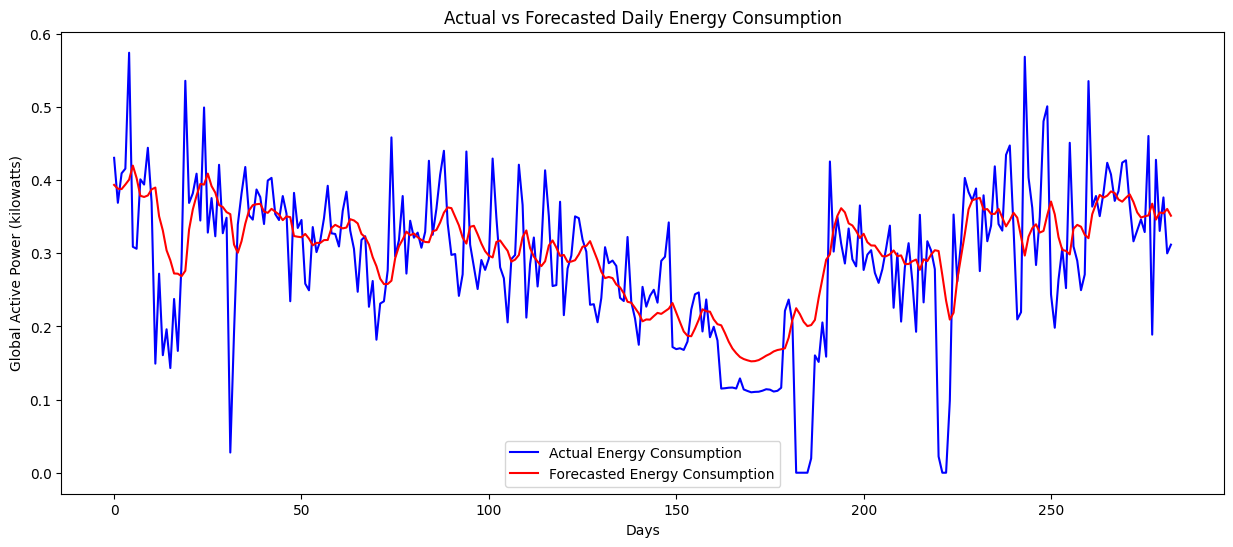

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Energy Consumption', color='blue')
plt.plot(y_pred, label='Forecasted Energy Consumption', color='red')
plt.title('Actual vs Forecasted Daily Energy Consumption')
plt.xlabel('Days')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

##### Plot Training and Validation Metrics

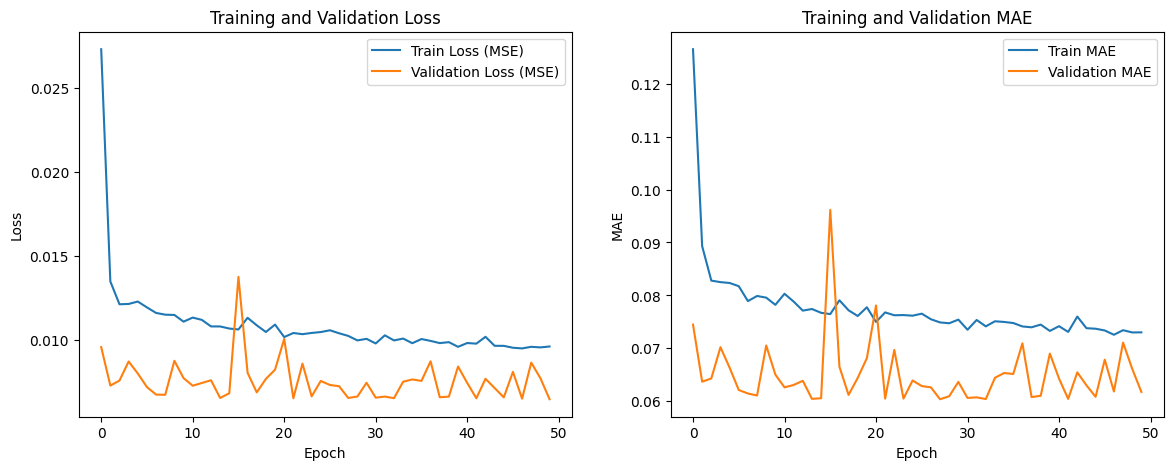

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

##### Save Observations

In [77]:
observations = f"""
Observations on Energy Consumption Forecasting:

Model Performance:
- The LSTM model achieved a Mean Absolute Error (MAE) of {mae:.3f} and a Root Mean Squared Error (RMSE) of {rmse:.3f}.
- The forecasted energy consumption closely follows the actual values, indicating good predictive performance.
- Training and validation loss decreased over epochs, showing that the model is learning effectively.
- MAE and RMSE metrics indicate the average deviation of predictions from actual values.

Potential Improvements:
- Experiment with different window sizes (e.g., 60 days) to capture longer temporal dependencies.
- Incorporate additional features such as temperature, day of the week, or holidays to improve forecasting accuracy.
- Tune hyperparameters such as the number of LSTM units, dropout rates, and learning rates.
- Implement more advanced architectures like stacked LSTMs or bidirectional LSTMs.
- Use techniques like Early Stopping and Model Checkpointing to prevent overfitting and save the best model.

Handling of Time Series Properties:
- *Temporal Dependencies*: The LSTM model effectively captures both short-term and long-term temporal dependencies in the energy consumption data.
- *Seasonality and Trends*: By using sequences of past data, the model can learn and predict recurring patterns and trends in energy usage.
- *Non-linear Relationships*: The LSTM layers with ReLU activation in the Dense layer help in modeling non-linear relationships in the data.
"""

with open('energy_forecasting_observations.txt', 'w') as f:
    f.write(observations)

print("Observations have been saved to 'energy_forecasting_observations.txt'.")

Observations have been saved to 'energy_forecasting_observations.txt'.
